In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.combine import SMOTEENN

In [2]:
df_telco_raw = pd.read_csv(r'data\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_telco_churn = df_telco_raw.copy()

**Summary of the data columns:**

- customerID          -> ID assigned to the customer
- gender              -> Whether the customer is a male or a female
- SeniorCitizen       -> Whether the customer is a senior citizen or not (1, 0)
- Partner             -> Whether the customer has a partner or not (Yes, No)
- Dependents          -> Whether the customer has dependents or not (Yes, No)
- tenure              -> Number of months the customer has stayed with the company
- PhoneService        -> Whether the customer has a phone service or not (Yes, No)
- MultipleLines       -> Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService     -> Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity      -> hether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup        -> Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection    -> Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport         -> Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV         -> Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies     -> Whether the customer has streaming movies or not (Yes, No, No internet service)
- Contract            -> The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling    -> Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod       -> The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges      -> The amount charged to the customer monthly
- TotalCharges        -> The total amount charged to the customer
- Churn               -> Whether the customer churned or not (Yes or No)

Now, lets gather the first information about the data.

In [3]:
df_telco_churn.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
df_telco_churn.nunique().sort_values()

Churn                  2
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PaperlessBilling       2
PhoneService           2
Contract               3
StreamingMovies        3
StreamingTV            3
TechSupport            3
OnlineBackup           3
OnlineSecurity         3
InternetService        3
MultipleLines          3
DeviceProtection       3
PaymentMethod          4
tenure                73
MonthlyCharges      1585
TotalCharges        6531
customerID          7043
dtype: int64

In [5]:
df_telco_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df_telco_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Focal points:**

- There are no missing values on the data.
- There are 3 datatypes detected initially, float, integer and object.
- There are, in total, 7043 rows and 21 columns on the dataset.
- The column 'SeniorCitizen' is the only one using (1,0) instead of (Yes, No) for the classification.
- The column 'TotalCharges' has been detected as an object, although we know it should be a float by the column description. That might have happened due to blank spaces in the data.

**Actions:**

- Remove 'customerID' column, as it's meaningless for the model we are building.
- We should conform the 'SeniorCitizen' column to the standard for now, using (Yes, No). This will assist the EDA.
- Remove possible errors from the column 'TotalCharges' and cast to float.


In [7]:
df_telco_churn.drop('customerID',axis=1, inplace=True)
df_telco_churn['SeniorCitizen'] = df_telco_churn['SeniorCitizen'].astype('str')
df_telco_churn['SeniorCitizen'] = df_telco_churn['SeniorCitizen'].str.replace('1', 'Yes')
df_telco_churn['SeniorCitizen'] = df_telco_churn['SeniorCitizen'].str.replace('0', 'No')

In [8]:
#finding if there are blank spaces
print(df_telco_churn[df_telco_churn['TotalCharges']==' '])

      gender SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female            No     Yes        Yes       0           No   
753     Male            No      No        Yes       0          Yes   
936   Female            No     Yes        Yes       0          Yes   
1082    Male            No     Yes        Yes       0          Yes   
1340  Female            No     Yes        Yes       0           No   
3331    Male            No     Yes        Yes       0          Yes   
3826    Male            No     Yes        Yes       0          Yes   
4380  Female            No     Yes        Yes       0          Yes   
5218    Male            No     Yes        Yes       0          Yes   
6670  Female            No     Yes        Yes       0          Yes   
6754    Male            No      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 No           

We can see that the blank spaces are inserted where the tenure is 0, so there should be no values for 'TotalCharges', because the clients are new to the service, they didn't pay the first month yet. We should replace the blank spaces with zeros.

In [9]:
df_telco_churn['TotalCharges'] = df_telco_churn['TotalCharges'].str.replace(' ', '0')
df_telco_churn['TotalCharges'] = df_telco_churn['TotalCharges'].astype('float64')

Now that we handled the first changes, we should separate categorical and numeric features for the EDA, as well as isolate the target. We can use the Summary of the data columns for that.

In [10]:
df_telco_churn.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [11]:
cat_features = ['gender', 'PaperlessBilling', 'PhoneService', 'Partner',
       'SeniorCitizen', 'Dependents', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'OnlineBackup', 'PaymentMethod']

num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

target = 'Churn'

# Exploratory data analysis

Now, lets perform the Exploratory data analysis, i.e., EDA. Our objective is to gain insights from the data, understanding hidden patterns, anomalies and correlation, before starting to build any kind of machine learning model. We are going to separe the analysis in three parts, the study of the numerical features, categorical features and the target.

## Numerical Features

In order to analyze the numerical features, we will build 3 graphs. The boxblots will display how the data is spread out and if there are any outliers. The pairplot will show us the pairwise relationships of the features, exploring possible correlations. The density estimate plots will describe the relationship of the numerical features with the target, therefore, investigating possible correlations between them.

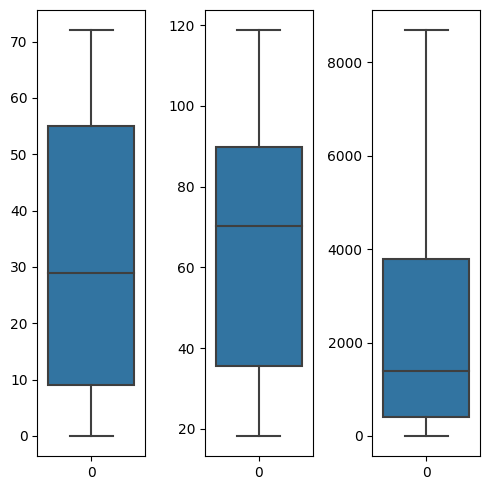

In [12]:
#building the boxplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(5,5)
sns.boxplot(data=df_telco_churn['tenure'], ax=ax1)
sns.boxplot(data=df_telco_churn['MonthlyCharges'], ax=ax2)
sns.boxplot(data=df_telco_churn['TotalCharges'], ax=ax3)
fig.tight_layout()
plt.show();

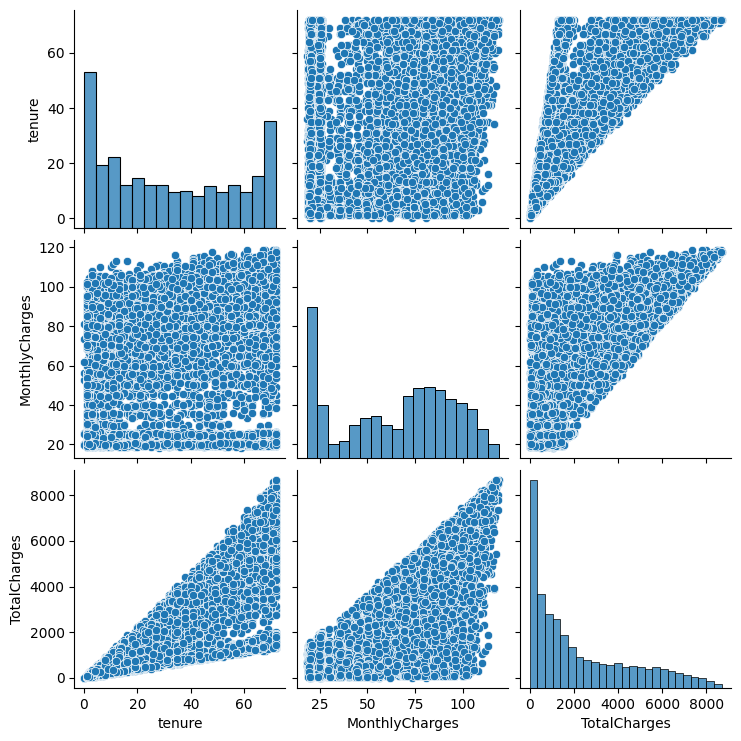

In [13]:
#building the pairplot
sns.pairplot(data=df_telco_churn[num_features])

In [14]:
#inspecting the pearson correlation coefficients for precise analysis
print(np.corrcoef(df_telco_churn[num_features], rowvar=False))

[[1.         0.24789986 0.8261784 ]
 [0.24789986 1.         0.65117383]
 [0.8261784  0.65117383 1.        ]]


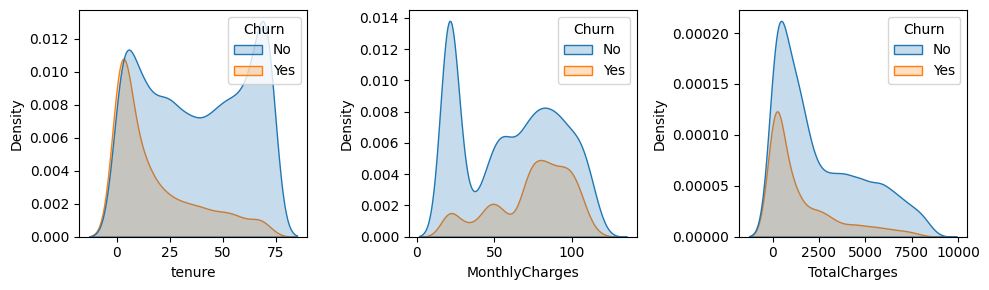

In [15]:
#building the density estimate plots
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(10,3)
sns.kdeplot(df_telco_churn, x='tenure', hue=target, ax=ax1, fill=True)
sns.kdeplot(df_telco_churn, x='MonthlyCharges', hue=target, ax=ax2, fill=True)
sns.kdeplot(df_telco_churn, x='TotalCharges', hue=target, ax=ax3, fill=True)
fig.tight_layout()
plt.show()

**Focal points:**

- There are no apparent outliers in the data, according to the boxplots.
- The feature 'TotalCharges' presented a significant correlation with the other features on the pairplot analysis, and a low correlation with the Target, as observed in the density estimate plot. That leads us to think that the feature might not be very useful for our model.

**Actions:**

- Remove the feature 'TotalCharges' from the dataframe and update the num_features list.

In [16]:
df_telco_churn.drop('TotalCharges',axis=1, inplace=True)

In [17]:
num_features = ['tenure', 'MonthlyCharges']

## Categorical Features

As for the categorical features, we should investigate their relationship with the target, to understand which will be most useful for our prediction. Considering that the target is also categorical, a great tool to display that kind of relationship is the histogram. We will plot a histogram for each feature, contrasting the distribution of customer behavior for each class of that feature. The features in which the distribution of customer behavior is similar for each class, might not be very useful for predicting the customer behavior later on.

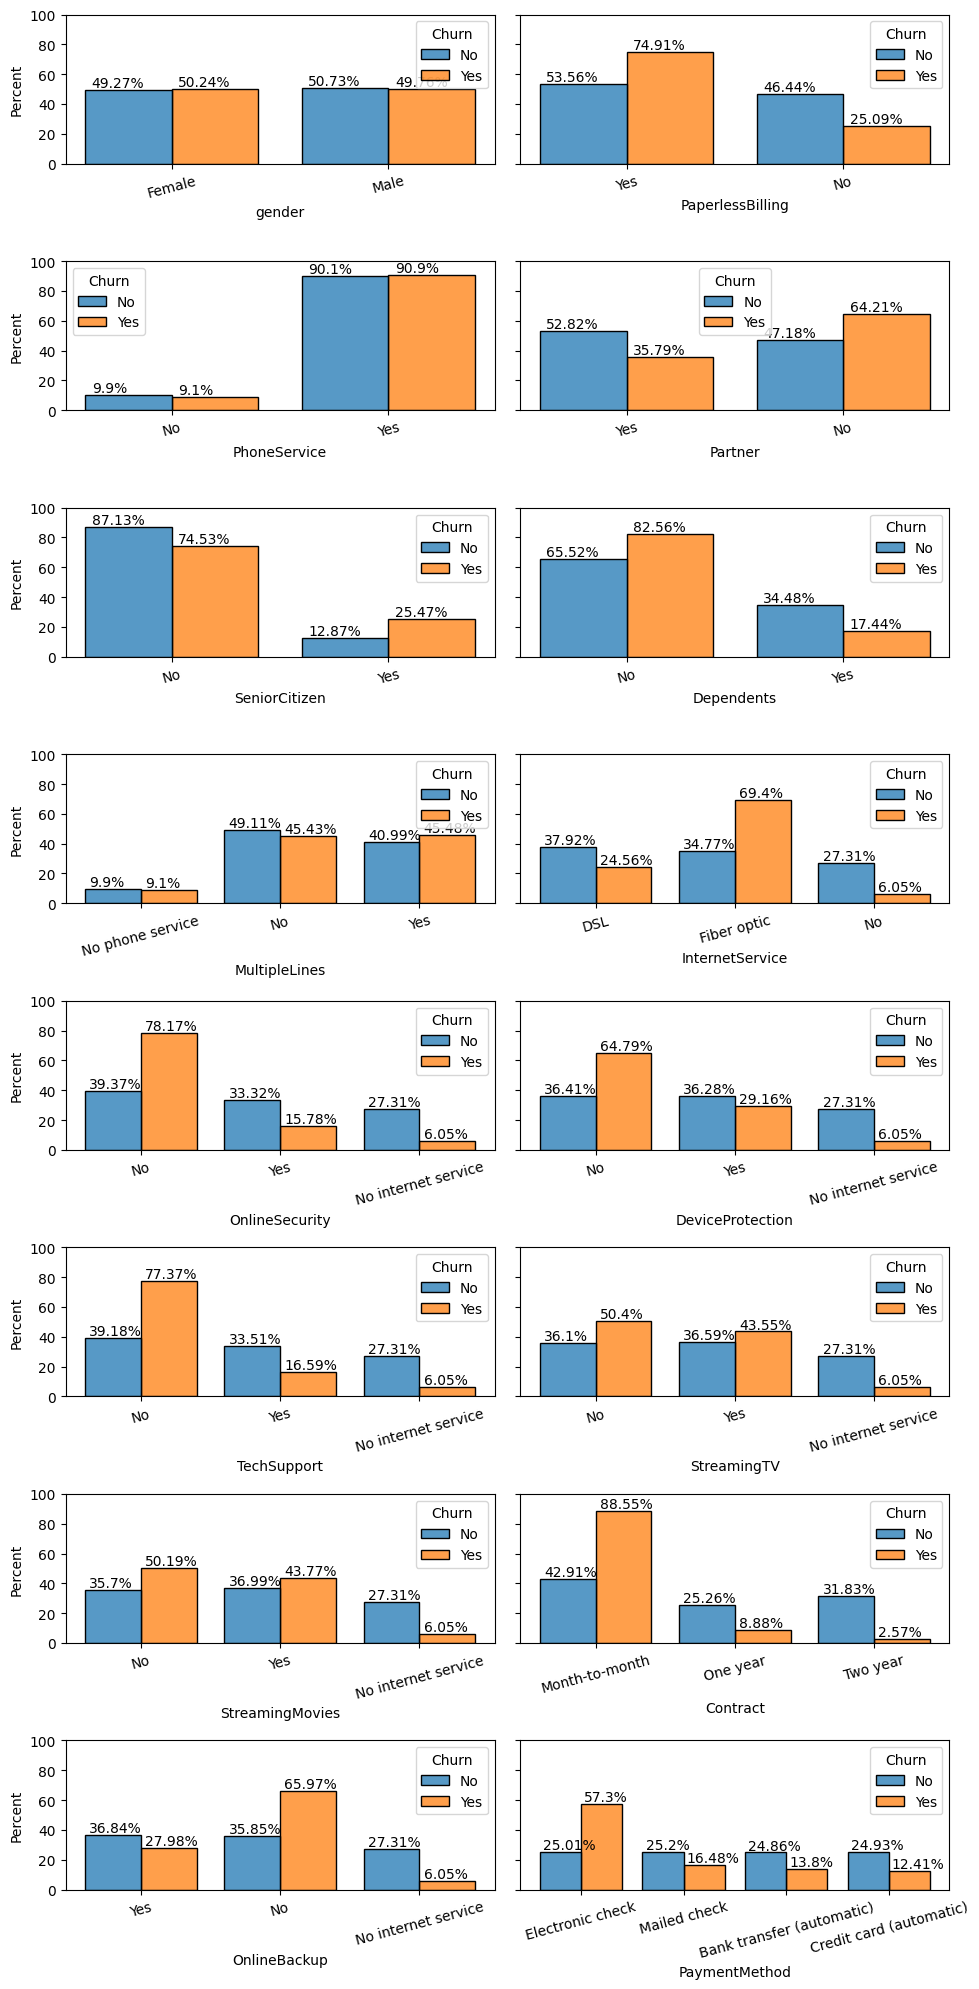

In [18]:
fig, axs = plt.subplots(8,2, sharey=True)
fig.set_size_inches(10,20)
k = 0
for i in range(8):
    for j in range (2):
        graph = sns.histplot(data=df_telco_churn, x=cat_features[k], hue=target, multiple="dodge", 
                  stat='percent', shrink = 0.8, common_norm=False, ax=axs[i,j]);
        axs[i,j].set_ylim(0,100)

        for patch in axs[i,j].patches:
            txt = str(patch.get_height().round(2)) + '%'
            txt_x = patch.get_x()+0.03
            txt_y = patch.get_height()+2
            axs[i,j].text(txt_x,txt_y,txt)
        k += 1

        plt.setp(axs[i,j].get_xticklabels(), rotation=15)
fig.tight_layout()
plt.show();

**Focal points:**

- The features 'gender', 'PhoneService' and 'MultipleLines' showed a high similarity in the distribution of customers who did and didn't churn for each class, so they might not be very useful for our model.

**Actions:**

- Remove the features 'gender', 'PhoneService' and 'MultipleLines' from the dataframe and update de cat_features list.

In [19]:
df_telco_churn.drop(['gender', 'PhoneService', 'MultipleLines'],axis=1, inplace=True)

In [20]:
cat_features = ['PaperlessBilling', 'Partner',
       'SeniorCitizen', 'Dependents', 'InternetService',
       'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'OnlineBackup', 'PaymentMethod']

## Target

As for the target, there is always a simple and important question to make: Are the classes balanced? Imbalanced classes can lead to bias when building machine learning models.

In [21]:
counts = df_telco_churn[target].value_counts()
print(
f"""
Positive Class
Count: {counts[1]}
Percentage: {round(counts[1]/(counts[1]+counts[0])*100,2)}%

Negative Class
Count: {counts[0]}
Percentage: {round((1-(counts[1]/(counts[1]+counts[0])))*100,2)}%
"""
)



Positive Class
Count: 1869
Percentage: 26.54%

Negative Class
Count: 5174
Percentage: 73.46%



**Focal points:**

- There is class imbalance in the target column, there are much more negative observations.

**Actions:**

- We should test using a balancing technique when building the models.

# Model building

Now that the EDA is done and we took the desired actions to clean the data, it's time to begin building machine learning models.Before building the models, we are going to take two important steps: 
- We should replace the target string classes with boolean values, so they are meaningful to the algorithms.
- To guarantee that the model is going to perform well with unseen data, we have to split the dataset, reserving a fraction to be used for testing.

In [22]:
#replacing the target classes with boolean values
df_telco_churn[target].replace({'Yes':1, 'No':0},inplace=True)

In [23]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    df_telco_churn.drop(columns=target),
    df_telco_churn[target],
    train_size=0.7,
    random_state=42,
    stratify=df_telco_churn[target]
)

## Building Baseline Logistic Regression Model

At first, we should build a baseline model to give us the understanding of how well a basic estimator will perform, so we can compare it later with the more advanced models.

In [24]:
#building baseline model pipeline
num_transformer_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

pre_processor = ColumnTransformer([
    ('num_transformer', num_transformer_pipe, num_features),
    ('cat_transformer', cat_transformer_pipe, cat_features)
])

base_logreg_pipe = Pipeline([
    ('pre_processor', pre_processor),
    ('estimator', LogisticRegression(random_state=42))
])

base_logreg_pipe

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PaperlessBilling',
                                                   'Partner', 'SeniorCitizen',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract', 'OnlineBackup',
                                                   'PaymentMethod'])])),
                ('estimator', LogisticRegression(random_state=42))])

In [25]:
#fit and predict
base_logreg_pipe.fit(X_train,y_train)
y_pred_base_logreg = base_logreg_pipe.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred_base_logreg))
print(f'roc_auc_score: {roc_auc_score(y_test,y_pred_base_logreg)}')

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1552
           1       0.65      0.54      0.59       561

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113

roc_auc_score: 0.7172184243894371


With the baseline model

## Tuning and Testing Models

In [27]:
def get_pipeline_smoteenn(num_features: list, cat_features: list, estimator):
    pipe_tr_num_features = Pipeline([
        ('tr_min_max', StandardScaler())
    ])

    pipe_tr_cat_features = Pipeline([
        ('tr_dummy', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    pre_processor = ColumnTransformer([
        ('tr_num', pipe_tr_num_features, num_features),
        ('tr_cat', pipe_tr_cat_features, cat_features)
    ])

    smoteenn = SMOTEENN(random_state=42)

    final_pipe = Pipeline([
        ('pre_processor', pre_processor),
        ('smoteenn', smoteenn),
        ('estimator', estimator)
    ])

    return final_pipe

### Logistic Regression Model

In [28]:
logreg_pipe = get_pipeline_smoteenn(num_features=num_features, cat_features=cat_features, estimator=LogisticRegression(random_state=42))
logreg_pipe

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_min_max',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('tr_cat',
                                                  Pipeline(steps=[('tr_dummy',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PaperlessBilling',
                                                   'Partner', 'SeniorCitizen',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract', 'OnlineBackup',
                                                   'PaymentMethod'])])),
                ('smoteenn', SMOTEENN(random_state=42)),
                ('estimator', LogisticRegression(random_state=42))])

In [29]:
param_dist_logreg = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C':[0.01, 0.1, 1, 10],
    'estimator__solver':['lbfgs', 'liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand_logreg = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_dist_logreg,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-2,
    verbose=5,
    random_state=42
)

In [30]:
rand_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Guilerme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Guilerme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Guilerme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\l

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('tr_num',
                                                                               Pipeline(steps=[('tr_min_max',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges']),
                                                                              ('tr_cat',
                                                                               Pipeline(steps=[('tr_dummy',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['PaperlessBil...
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'Contract',
                                                                                'OnlineBackup',
                                                                                'PaymentMethod'])])),
                                             ('smoteenn',
                                              SMOTEENN(random_state=42)),
                                             ('estimator',
                                              LogisticRegression(random_state=42))]),
                   n_jobs=-2,
                   param_distributions={'estimator__C': [0.01, 0.1, 1, 10],
                                        'estimator__penalty': ['l1', 'l2'],
                                        'estimator__solver': ['lbfgs',
                                                              'liblinear']},
                   random_state=42, scoring='roc_auc', verbose=5)

In [31]:
y_pred_logreg = rand_logreg.predict(X_test)
print(classification_report(y_test, y_pred_logreg))

rand_logreg.best_params_

              precision    recall  f1-score   support

           0       0.92      0.64      0.76      1552
           1       0.46      0.85      0.60       561

    accuracy                           0.70      2113
   macro avg       0.69      0.75      0.68      2113
weighted avg       0.80      0.70      0.72      2113



{'estimator__solver': 'liblinear',
 'estimator__penalty': 'l1',
 'estimator__C': 0.1}

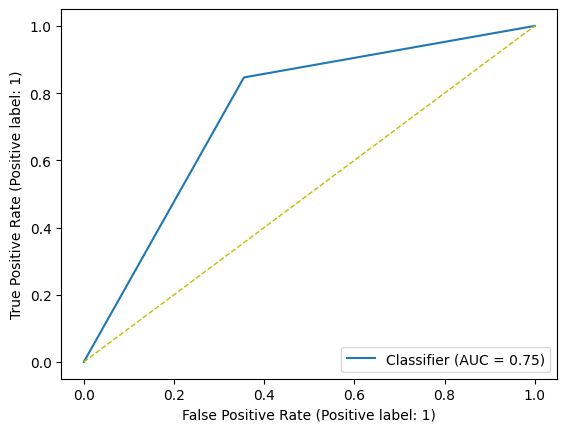

In [32]:
RocCurveDisplay.from_predictions(y_test, y_pred_logreg)
plt.plot([0,1], [0,1], '--', color = 'y', linewidth= 1)
plt.show()

### Random Forest Model

In [33]:
forest_pipe = get_pipeline_smoteenn(num_features=num_features, cat_features=cat_features, estimator=RandomForestClassifier(random_state=42))
forest_pipe

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_min_max',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('tr_cat',
                                                  Pipeline(steps=[('tr_dummy',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PaperlessBilling',
                                                   'Partner', 'SeniorCitizen',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract', 'OnlineBackup',
                                                   'PaymentMethod'])])),
                ('smoteenn', SMOTEENN(random_state=42)),
                ('estimator', RandomForestClassifier(random_state=42))])

In [34]:
param_dist_forest = {
    'estimator__n_estimators': [10,100,200],
    'estimator__criterion':['gini', 'entropy', 'log_loss'],
    'estimator__max_depth':[1, 15, 30],
    'estimator__max_leaf_nodes':[5, 15, 30],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand_forest = RandomizedSearchCV(
    estimator=forest_pipe,
    param_distributions=param_dist_forest,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-2,
    verbose=5,
    random_state=42
)

In [35]:
rand_forest.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('tr_num',
                                                                               Pipeline(steps=[('tr_min_max',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges']),
                                                                              ('tr_cat',
                                                                               Pipeline(steps=[('tr_dummy',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['PaperlessBil...
                                                                                'PaymentMethod'])])),
                                             ('smoteenn',
                                              SMOTEENN(random_state=42)),
                                             ('estimator',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-2,
                   param_distributions={'estimator__criterion': ['gini',
                                                                 'entropy',
                                                                 'log_loss'],
                                        'estimator__max_depth': [1, 15, 30],
                                        'estimator__max_leaf_nodes': [5, 15,
                                                                      30],
                                        'estimator__n_estimators': [10, 100,
                                                                    200]},
                   random_state=42, scoring='roc_auc', verbose=5)

In [36]:
y_pred_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_forest))

rand_forest.best_params_

              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1552
           1       0.48      0.84      0.61       561

    accuracy                           0.71      2113
   macro avg       0.70      0.75      0.69      2113
weighted avg       0.80      0.71      0.73      2113



{'estimator__n_estimators': 100,
 'estimator__max_leaf_nodes': 30,
 'estimator__max_depth': 15,
 'estimator__criterion': 'log_loss'}

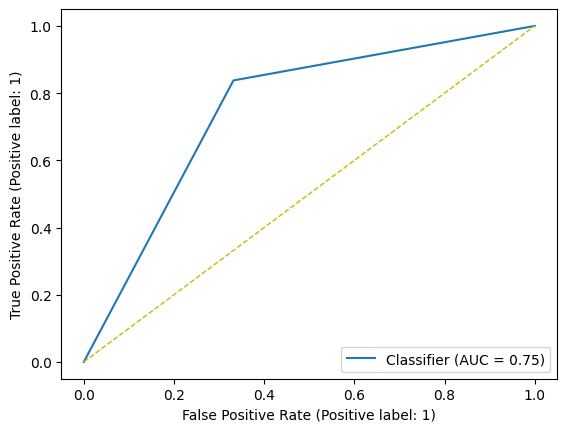

In [37]:
RocCurveDisplay.from_predictions(y_test, y_pred_forest)
plt.plot([0,1], [0,1], '--', color = 'y', linewidth= 1)
plt.show()

### AdaBoost Model

In [38]:
ada_pipe = get_pipeline_smoteenn(num_features=num_features, cat_features=cat_features, estimator=AdaBoostClassifier(random_state=42))
ada_pipe

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_min_max',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('tr_cat',
                                                  Pipeline(steps=[('tr_dummy',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PaperlessBilling',
                                                   'Partner', 'SeniorCitizen',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract', 'OnlineBackup',
                                                   'PaymentMethod'])])),
                ('smoteenn', SMOTEENN(random_state=42)),
                ('estimator', AdaBoostClassifier(random_state=42))])

In [39]:
param_dist_ada = {
 'estimator__n_estimators': [50, 100, 200],
 'estimator__learning_rate' : [0.01,0.05,0.1,0.3,1],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand_ada = RandomizedSearchCV(
    estimator=ada_pipe,
    param_distributions=param_dist_ada,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-2,
    verbose=5,
    random_state=42
)

In [40]:
rand_ada.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('tr_num',
                                                                               Pipeline(steps=[('tr_min_max',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges']),
                                                                              ('tr_cat',
                                                                               Pipeline(steps=[('tr_dummy',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['PaperlessBil...
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'Contract',
                                                                                'OnlineBackup',
                                                                                'PaymentMethod'])])),
                                             ('smoteenn',
                                              SMOTEENN(random_state=42)),
                                             ('estimator',
                                              AdaBoostClassifier(random_state=42))]),
                   n_jobs=-2,
                   param_distributions={'estimator__learning_rate': [0.01, 0.05,
                                                                     0.1, 0.3,
                                                                     1],
                                        'estimator__n_estimators': [50, 100,
                                                                    200]},
                   random_state=42, scoring='roc_auc', verbose=5)

In [41]:
y_pred_ada = rand_ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

rand_ada.best_params_

              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1552
           1       0.47      0.86      0.61       561

    accuracy                           0.71      2113
   macro avg       0.70      0.75      0.69      2113
weighted avg       0.81      0.71      0.72      2113



{'estimator__n_estimators': 50, 'estimator__learning_rate': 0.3}

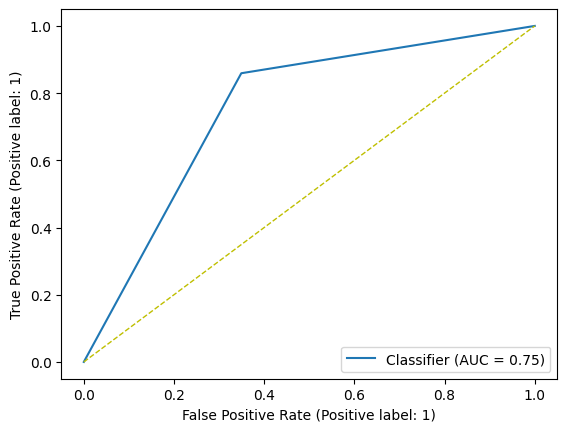

In [42]:
RocCurveDisplay.from_predictions(y_test, y_pred_ada)
plt.plot([0,1], [0,1], '--', color = 'y', linewidth= 1)
plt.show()

### XGBoost Model

In [43]:
xgb_pipe = get_pipeline_smoteenn(num_features=num_features, cat_features=cat_features, estimator=XGBClassifier(random_state=42))
xgb_pipe

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_min_max',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('tr_cat',
                                                  Pipeline(steps=[('tr_dummy',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['PaperlessBilling',
                                                   'Partner', 'SeniorCitizen',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'DevicePr...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [44]:
param_dist_xgb = {
    'estimator__learning_rate': [0.01, 0.1, 0.15, 0.2],
    'estimator__alpha': [0.01, 0.3, 0.8, 1],
    'estimator__colsample_bytree': [0.1, 0.4, 0.8, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand_xgb = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist_xgb,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-2,
    verbose=5,
    random_state=42
)

In [45]:
rand_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('tr_num',
                                                                               Pipeline(steps=[('tr_min_max',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges']),
                                                                              ('tr_cat',
                                                                               Pipeline(steps=[('tr_dummy',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['PaperlessBil...
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=42, ...))]),
                   n_jobs=-2,
                   param_distributions={'estimator__alpha': [0.01, 0.3, 0.8, 1],
                                        'estimator__colsample_bytree': [0.1,
                                                                        0.4,
                                                                        0.8,
                                                                        1],
                                        'estimator__learning_rate': [0.01, 0.1,
                                                                     0.15,
                                                                     0.2]},
                   random_state=42, scoring='roc_auc', verbose=5)

In [46]:
y_pred_xgb = rand_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

print(rand_xgb.best_params_)

print(rand_xgb.best_score_)

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1552
           1       0.52      0.81      0.63       561

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.72      2113
weighted avg       0.81      0.75      0.76      2113

{'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 0.4, 'estimator__alpha': 0.01}
0.8393517945307625


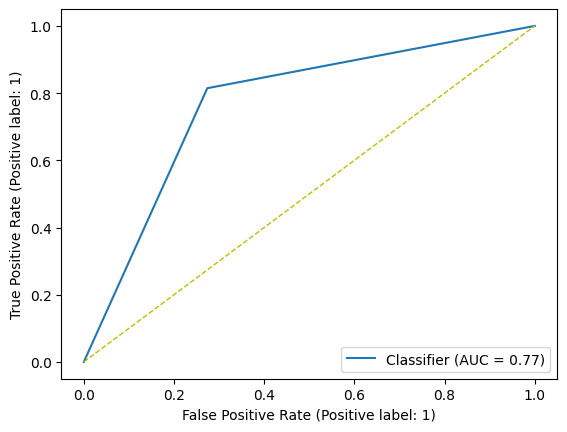

In [47]:
RocCurveDisplay.from_predictions(y_test, y_pred_xgb)
plt.plot([0,1], [0,1], '--', color = 'y', linewidth= 1)
plt.show()

In [48]:
print(rand_logreg.best_score_)
print(rand_forest.best_score_)
print(rand_ada.best_score_)
print(rand_xgb.best_score_)

0.8392750270564105
0.8382209583072431
0.8460178085148607
0.8393517945307625


## Building The Final Model With XGBoost